# Obuka dubokih neuronkih mreza

In [20]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

## Problemi nestajucih/eksplodirajucih gradijenta

Cesto gradijenti postaju sve manji i manji kako algoritam napreduje ka nizim slojevima, zbog toga se pri azuriranju gradijentnog spusta vrednosti parametara jako malo menjaju i algoritam ne konvergira. Takodje moze doci do eksplodirajucih gradijenta gde parametri postaju besmisleno vezi zbog velikih gradijenta.

Inicijalizacijom preko normalne distribucije i koriscenjem logisticke funkcije dokazano je da je varijasna na izlaznim slojevima mnogo veca nego na ulaznim (visi slojevi su osetljiviji od nizih). Varijansa na visim slojevima raste dok ne nastupi zasicenje aktivirajuce funkije na visim slojevima.<br>

In [6]:
def logit(z):
  return 1 / (1 + np.exp(-z))

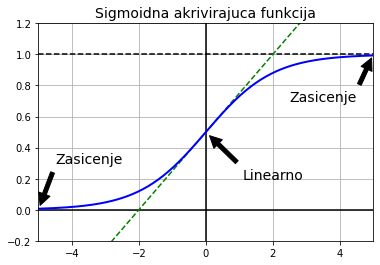

In [7]:
z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Zasicenje', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Zasicenje', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linearno', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoidna akrivirajuca funkcija", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

plt.show()

Vrednosti na jako viskom i niskim vrednostima postaju 0 i 1 a izvod funkcije postaje blizu 0. Kada se pusti propagacija gotovo da nema gradijenta koji propagirali.

### Glorotova i Heova inicijalizacija

Glorot i Bengio su dosli do zakljucka da nam je potreban signal koji pravilno tece u oba smera bez da taj signal nestaje ili eksplodira. Da bi se ovako nesto postiglo potrebno je da varijansa izlaza svakog sloja treba da bude jednaka varijansi njegovih ulaza (primer vise pojacala koja se povezuju, signal od proslih treba da bude takav da ga novo pojacalo primi bez da taj signal bude prejak ili preslab).

<b>Glorotova jednacina</b><br>
Normalna distribucija sa srednjom vrednoscu 0 i varijansom $\sigma^2=\frac{1}{fan_{avg}}$<br><br>
gde je $fan_{avg}$ srednja vrednost broja ulaza $fan_{in}$ i broja izlaza $fan_{out}$

LeCunova strategija zamenjuje $fan_{avg}$ sa $fan_{in}$

| Inicijalizacija | Aktivirajuce funkcije | $\sigma^2$ (Normalna) |
| --- | --- | --- |
| Glorotova | None, tanh, logisticka, softmax | 1 / $fan_{avg}$ |
| Heova | ReLU i varinajte | 2 / $fan_{in}$ |
| LeCunova | SELU | 1 / $fan_{in}$ |


Keras standardno koristi Glorotovu inicijalizaciju.

In [9]:
# Heova inicijalizacija
keras.layers.Dense(10, activation='relu', kernel_initializer='he_normal')

### Nezasicene aktivirajuce funkcije

Delimican uzrok problema s nestabilnim gradijentima je los izbor aktivirajuce funkije. Logisticka je jako losa zbog zasicenja dok je ReLU bolja jer nema zasicenja na pozitivnim vrednostima i lako se izracunava.

Ali ni ReLU funkcija nije savrsena. Pati od problema <i>umiruci ReLU</i> tj. neki neuroni proizvode samo nule na izlazima. To se dogadja kada je ponderisan zbir svih ulaza za sve trening skupove negativan, a gradijentni spust ne deluje na njega jer je gradijent funckije ReLU jednak nuli kada je ulaz funkcije negativan

Za resenje ovog problema potrebna nam je varijanta funkcije ReLU kao sto je <i>cureca ReLU</i> koje je difinisana kao $LeakyReLU_\alpha(z) = max(\alpha z,z)$ gde je $\alpha$ nagib funkcije za z < 0.

In [10]:
def leaky_relu(z, alpha=0.01):
  return np.maximum(alpha*z, z)

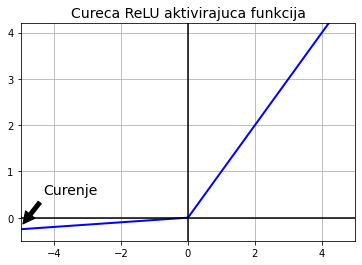

In [11]:
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Curenje', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Cureca ReLU aktivirajuca funkcija", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

plt.show()

In [24]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [35]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(10, activation="softmax")
])

In [36]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=['accuracy'])

In [37]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 5s 3ms/step - loss: 1.3461 - accuracy: 0.6209 - val_loss: 0.9255 - val_accuracy: 0.7184
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.8197 - accuracy: 0.7355 - val_loss: 0.7306 - val_accuracy: 0.7632
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.6966 - accuracy: 0.7693 - val_loss: 0.6565 - val_accuracy: 0.7882
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.6332 - accuracy: 0.7908 - val_loss: 0.6003 - val_accuracy: 0.8048
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5918 - accuracy: 0.8057 - val_loss: 0.5656 - val_accuracy: 0.8182
Epoch 6/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5619 - accuracy: 0.8135 - val_loss: 0.5406 - val_accuracy: 0.8238
Epoch 7/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5390 - accuracy: 0.8206 - val_loss: 0.5196 - val_accuracy:

Nakon LeakyReLU funkcije predlozena je nova aktivirajuca funkcija <i>eksponencijalna linearna jedinica ELU</i> koja je nadmasila performanse LeakyReLU funkcije. 

In [12]:
def elu(z, alpha=1):
  return np.where(z < 0, alpha * (np.exp(z) - 1), z)

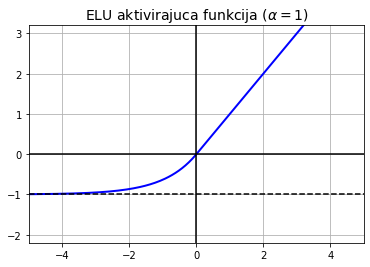

In [13]:
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU aktivirajuca funkcija ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

plt.show()

Funkcija ELU ima mnogo prednosti nad ReLU aktivirajucom funkcijaom:
1. Njena vrednost je negativna kada je z < 0 sto resava problem nestajucih gradijenta. 
2. Ima gradijent razlicit od nule za z < 0 cime se izbegava problem mrtvih neurona.
3. Ako je $\alpha$ jednako 1 funkcija je svuda glatka i u blizini z = 0 sto doprinosi ubrzavanju gradijetnog spusta jer nema mnogo skakutanja levo desno.

Ali funkcija ELU ima i manu: sporije se izracunava od funkcije ReLU. U vreme testiranja ELU mreza ce biti sporija od ReLU mreze.

Nakon toga otkrivena je aktivirajuca funkcija skaliraja ELU (SELU). Ako se NN sastoji samo od gustih slove sa SELU aktivirajucom funkcijom i LeCunovom inicijalizacijom, NN ce se samonormalizovati sto resava problema gradijenta. Rezultat ovoga je da SELU pruza bolje performanse od ostalih aktivirajucih funkcija. Problem sa SELU je da je samonormalizacija lako polomljena, nije moguce koristiti $l_1$ i $l_2$ regularizaciju, dropout ili bilo koju arhitekturu koja nije sekvencijalana.

In [14]:
from scipy.special import erfc

# alpha i scale za samonormalizovanje sa mena 0 i std dev 1
# (jednacina 14 u radu):
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)

In [15]:
def selu(z, scale=scale_0_1, alpha=alpha_0_1):
  return scale * elu(z, alpha)

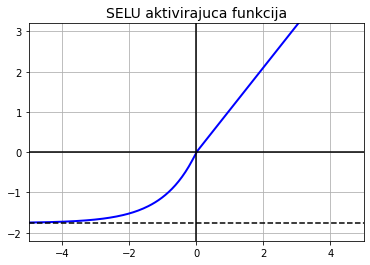

In [18]:
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title("SELU aktivirajuca funkcija", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

plt.show()

In [19]:
np.random.seed(42)
Z = np.random.normal(size=(500, 100)) # standardized inputs
for layer in range(1000):
    W = np.random.normal(size=(100, 100), scale=np.sqrt(1 / 100)) # LeCun initialization
    Z = selu(np.dot(Z, W))
    means = np.mean(Z, axis=0).mean()
    stds = np.std(Z, axis=0).mean()
    if layer % 100 == 0:
        print("Layer {}: mean {:.2f}, std deviation {:.2f}".format(layer, means, stds))

Layer 0: mean -0.00, std deviation 1.00
Layer 100: mean 0.02, std deviation 0.96
Layer 200: mean 0.01, std deviation 0.90
Layer 300: mean -0.02, std deviation 0.92
Layer 400: mean 0.05, std deviation 0.89
Layer 500: mean 0.01, std deviation 0.93
Layer 600: mean 0.02, std deviation 0.92
Layer 700: mean -0.02, std deviation 0.90
Layer 800: mean 0.05, std deviation 0.83
Layer 900: mean 0.02, std deviation 1.00


Treniranje NN na Fashion MNIST podacima

In [21]:
np.random.seed(42)
tf.random.set_seed(42)

In [22]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28,28]))
model.add(keras.layers.Dense(300, activation='selu', 
                             kernel_initializer=keras.initializers.lecun_normal))

for layer in range(99):
  model.add(keras.layers.Dense(100, activation='selu', 
                               kernel_initializer=keras.initializers.lecun_normal))
  
model.add(keras.layers.Dense(10, activation='softmax'))

2022-02-23 21:32:20.904964: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-23 21:32:21.104742: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-23 21:32:21.104993: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-23 21:32:21.105657: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [23]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics = ['accuracy'])

In [25]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [27]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 22s 13ms/step - loss: 1.2800 - accuracy: 0.5099 - val_loss: 1.1190 - val_accuracy: 0.5512
Epoch 2/5
1719/1719 [==============================] - 21s 12ms/step - loss: 0.8012 - accuracy: 0.7084 - val_loss: 0.6667 - val_accuracy: 0.7574
Epoch 3/5
1719/1719 [==============================] - 21s 12ms/step - loss: 0.6434 - accuracy: 0.7658 - val_loss: 0.6448 - val_accuracy: 0.7776
Epoch 4/5
1719/1719 [==============================] - 21s 12ms/step - loss: 0.5742 - accuracy: 0.7943 - val_loss: 0.5637 - val_accuracy: 0.7988
Epoch 5/5
1719/1719 [==============================] - 21s 12ms/step - loss: 0.5451 - accuracy: 0.8069 - val_loss: 0.5119 - val_accuracy: 0.8210


Koriscenje ReLU funkcije umesto SELU

In [30]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28,28]))
model.add(keras.layers.Dense(300, activation='relu', 
                             kernel_initializer=keras.initializers.he_normal))

for layer in range(99):
  model.add(keras.layers.Dense(100, activation='relu', 
                               kernel_initializer=keras.initializers.he_normal))
  
model.add(keras.layers.Dense(10, activation='softmax'))

In [31]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics = ['accuracy'])

In [32]:
history = model.fit(X_train, y_train, epochs=5,
                    validation_data=(X_valid, y_valid))

Epoch 1/5
1719/1719 [==============================] - 24s 12ms/step - loss: 1.9541 - accuracy: 0.2341 - val_loss: 1.5532 - val_accuracy: 0.3258
Epoch 2/5
1719/1719 [==============================] - 20s 12ms/step - loss: 1.3378 - accuracy: 0.4192 - val_loss: 1.0254 - val_accuracy: 0.5392
Epoch 3/5
1719/1719 [==============================] - 20s 12ms/step - loss: 1.0356 - accuracy: 0.5684 - val_loss: 0.8602 - val_accuracy: 0.6294
Epoch 4/5
1719/1719 [==============================] - 20s 12ms/step - loss: 1.1306 - accuracy: 0.5278 - val_loss: 0.9272 - val_accuracy: 0.6206
Epoch 5/5
1719/1719 [==============================] - 21s 12ms/step - loss: 0.9014 - accuracy: 0.6113 - val_loss: 0.9590 - val_accuracy: 0.6288


### Normalizacija paketa